# Predicción de podios en la Formula 1

En este proyecto vamos a analizar datos de la fórmula 1 para poder predecir si un piloto tendrá podio, es decir si queda en entre los primeros 3 lugares.

El enfoque se dará de los periodos 2019 - 2021 y 2022 - 2024 ya que los reglamentos se han modificado y queremos analizar si estos tienen un impacto en las variables a estudiar

## ¿Cómo es una carrera de Fórmula 1?

Para familiarizarnos con las base de datos y sus variables, veamos en qué consiste una carrera de fórmula 1

Cada año (*temporada*), se realizan distintas carreras al rededor del mundo (*rounds*) donde compiten equipos (*constructores*) con dos pilotos (*drivers*), con el objetivo de sumar los suficientes puntos para ganar los campenatos: constructores y pilotos

Cada carrera (*race*) se compone de:
* Tres prácticas libres (*fp*), donde los equipos y pilotos tienen una hora (cada día) para poner a prueba sus autos y tácticas encaminadas a la carrera

* *Qualifications* para determinar la posición (*position*) en la 'parrilla' (*grid*). El mejor tiempo saldrá desde la posición 1

    * Una Qualy se divide en 3:
    * Q1 donde compiten todos los equipos y se eliminan 5 pilotos;
    * Q2 se eliminan 5 pilotos;
    * Q3 los 10 pilotos restantes compiten para obtener el mejor tiempo

El piloto que obtenga la posición 1 en la Q3 se lleva la "pole position"

* La carrera; se compite por los puntos (los primeros diez sólo obtienen) que suman tanto para el campeonato de constructores y de pilotos. Cada circuito tiene una distancia y eso determina el número de vueltas (*laps*) a realizar

Teniendo contexto del funcionamiento, pasemos a describir las variables

## Descripción de las variables

Previamente hemos realizado la unión de las bases, ya que la información estaba seperada. Se puede ver en la libreta `construccion_base.ipynb`. Obtenemos una sola base llamada `RACES.csv`

* `raceId`: Identificador único para cada carrera.
* `circuitId`: identificador único para cada circuito
* `driverId`: identificador único para cada piloto
* `resultId`: identificador único para cada resultado
* `qualifyingId`: identificador único para cada qualification
* `year`: Año en que se realizó la carrera
* `circuitRef`: Nombre del circuito
* `driverRef`: nombre más usado por cada piloto
* `alt`: Altitud del circuito
* `stop`: número de pits realizados
* `pitlap`: Lap en la que se realizó un pit stop
* `pitduration`: tiempo en completar el pit
* `startposition`: posición de cada piloto al inicio de la carrera (resultado de las Q's)
* `endposition`: posición final del piloto en la carrera
* `laps`: cantidad de vueltas que cada piloto realizó en una carrera
* `fastestLapTime`: tiempo de la vuelta más rápida del piloto en la carrera dada
* `fastestLapSpeed`: velocidad máxima a la que el piloto llegó en su vuelta más rápida
* `lap`: número de lap en el circuito por cada piloto, por cada carrera
* `position`: historial de posición del piloto en la carrera
* `milliseconds`: tiempo en completar una vuelta. 60,000ms + segundos en ms en la carrera. Esta variable se transformará a `seconds`
* `qposition`: posición resultante en la Q
* `q1`, `q2`, `q3`: tiempo de la vuelta en las Q's
* `status`: indica si finalizó o no la carrera y por qué

Pasemos a la limpieza de la base para que los análisis sean homogeneos y los tipos de datos sean los correctos


In [149]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Limpieza de la base

In [131]:
races = pd.read_csv('f1_data/RACES.csv').drop(['resultId', 'qualifyId', 'driverId', 'circuitId'], axis=1)

## valores nulos

La base por naturaleza tiene valores nulos, por ejemplo en los tiempos de vuelta en la q2 tendrá 5 valores faltantes por cada carrera. Veamos la distribución

Consideraciones:

* La carrera realizada en spa de 2021, duró solamente 2 laps por condiciones de lluvia y fue cancelada. Por lo que será eliminada de la base (raceId = 1063)

In [132]:
races = races.drop(104515)

Vamos a reemplazar con 0 los valores nulos para poder realizar un data-casting de las variables

In [133]:
races = races.fillna(0)

## Convirtiendo tipos de datos

In [135]:
# convirtiendo year, circuitRef, driverRef, status como categorías
races[['year','circuitRef', 'driverRef', 'status']] = races[['year','circuitRef', 'driverRef', 'status']].astype('category')

In [136]:
# convirtiendo stop, pitlap, startposition, endposition, laps, lap, position, qposition como int64
races[['stop', 'pitlap', 'startposition', 'endposition', 'laps', 'lap', 'position','qposition']] = races[['stop', 'pitlap', 'startposition', 'endposition', 'laps', 'lap', 'position','qposition']].astype('int64')


Existen datos atípicos en la variable pitduration, no es posible que un pit dure más de un minuto y medio, por lo que vamos a borrar los registros que tengan esa condición

In [137]:
# eliminando datos con duración de pits inusuales
races = races[~races['pitduration'].str.contains(':', na=False)]

In [138]:
# Convirtiendo pitduration a segundos
races['pitduration'] = races['pitduration'].astype('float')

In [139]:
# convirtiendo fastestLapTime, q1, q2, q3 a segundos

races['fastestLapTime'] = races['fastestLapTime']. apply(
    lambda x: (int(x.split(':')[0]) * 60 + int(x.split(':')[1].split('.')[0]) + (int(x.split(':')[1].split('.')[1]) / 1000 if '.' in x else 0) if x != 0 else 0
    ))

races['q1'] = races['q1']. apply(
    lambda x: (int(x.split(':')[0]) * 60 + int(x.split(':')[1].split('.')[0]) + (int(x.split(':')[1].split('.')[1]) / 1000 if '.' in x else 0) if x != 0 else 0
    ))

races['q2'] = races['q2']. apply(
    lambda x: (int(x.split(':')[0]) * 60 + int(x.split(':')[1].split('.')[0]) + (int(x.split(':')[1].split('.')[1]) / 1000 if '.' in x else 0) if x != 0 else 0
    ))

races['q3'] = races['q3']. apply(
    lambda x: (int(x.split(':')[0]) * 60 + int(x.split(':')[1].split('.')[0]) + (int(x.split(':')[1].split('.')[1]) / 1000 if '.' in x else 0) if x != 0 else 0
    ))


In [140]:
# convirtiendo milliseconds a segundos
races['milliseconds'] = races['milliseconds'].apply(lambda x: x/1000)

In [143]:
# renombrando
races = races.rename(columns={'milliseconds': 'seconds'})

In [144]:
races

,raceId,year,circuitRef,driverRef,alt,stop,pitlap,pitduration,startposition,endposition,...,fastestLapTime,fastestLapSpeed,lap,position,seconds,qposition,q1,q2,q3,status
0,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,1,19,146.128,20,86.067,0.000,0.0,+3 Laps
1,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,2,19,99.740,20,86.067,0.000,0.0,+3 Laps
2,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,3,19,92.317,20,86.067,0.000,0.0,+3 Laps
3,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,4,20,93.683,20,86.067,0.000,0.0,+3 Laps
4,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,5,20,93.218,20,86.067,0.000,0.0,+3 Laps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269943,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,53,16,90.215,15,83.632,83.877,0.0,+1 Lap
269944,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,54,16,91.204,15,83.632,83.877,0.0,+1 Lap
269945,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,55,16,91.958,15,83.632,83.877,0.0,+1 Lap
269946,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,56,16,112.994,15,83.632,83.877,0.0,+1 Lap


In [146]:
races.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248119 entries, 0 to 269947
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   raceId           248119 non-null  int64   
 1   year             248119 non-null  category
 2   circuitRef       248119 non-null  category
 3   driverRef        248119 non-null  category
 4   alt              248119 non-null  int64   
 5   stop             248119 non-null  int64   
 6   pitlap           248119 non-null  int64   
 7   pitduration      248119 non-null  float64 
 8   startposition    248119 non-null  int64   
 9   endposition      248119 non-null  int64   
 10  laps             248119 non-null  int64   
 11  fastestLapTime   248119 non-null  float64 
 12  fastestLapSpeed  248119 non-null  float64 
 13  lap              248119 non-null  int64   
 14  position         248119 non-null  int64   
 15  seconds          248119 non-null  float64 
 16  qposition        248119 n

# Circuitos

## Supuestos

* Del periodo 2019-2021 y 2022-2024 no varía en cuanto a resultados esperados
* Cada carrera es independiente de las demás
*

## Objetivo del análisis
Analizar qué variables influyen significativamente para obtener podio en una carrera, es decir obtener una posición final en como primero, segundo o tercer lugar

Este estudio se hará específicamente por circuito, ya que las características de cada uno son distintas

Veamos la distribución de los circuitos durante los 6 años

In [187]:
races

,raceId,year,circuitRef,driverRef,alt,stop,pitlap,pitduration,startposition,endposition,...,fastestLapTime,fastestLapSpeed,lap,position,seconds,qposition,q1,q2,q3,status
0,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,1,19,146.128,20,86.067,0.000,0.0,+3 Laps
1,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,2,19,99.740,20,86.067,0.000,0.0,+3 Laps
2,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,3,19,92.317,20,86.067,0.000,0.0,+3 Laps
3,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,4,20,93.683,20,86.067,0.000,0.0,+3 Laps
4,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,5,20,93.218,20,86.067,0.000,0.0,+3 Laps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269943,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,53,16,90.215,15,83.632,83.877,0.0,+1 Lap
269944,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,54,16,91.204,15,83.632,83.877,0.0,+1 Lap
269945,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,55,16,91.958,15,83.632,83.877,0.0,+1 Lap
269946,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,56,16,112.994,15,83.632,83.877,0.0,+1 Lap


In [211]:
year_circuit = races.groupby(['year', 'circuitRef', 'raceId'])
year_circuit = year_circuit.nth(1)
year_circuit = year_circuit.circuitRef.value_counts().reset_index()

/tmp/ipykernel_12025/308743424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_circuit = races.groupby(['year', 'circuitRef', 'raceId'])


In [212]:
year_circuit

,circuitRef,count
0,red_bull_ring,8
1,silverstone,7
2,bahrain,7
3,monza,6
4,yas_marina,6
5,hungaroring,6
6,catalunya,6
7,baku,5
8,americas,5
9,spa,5


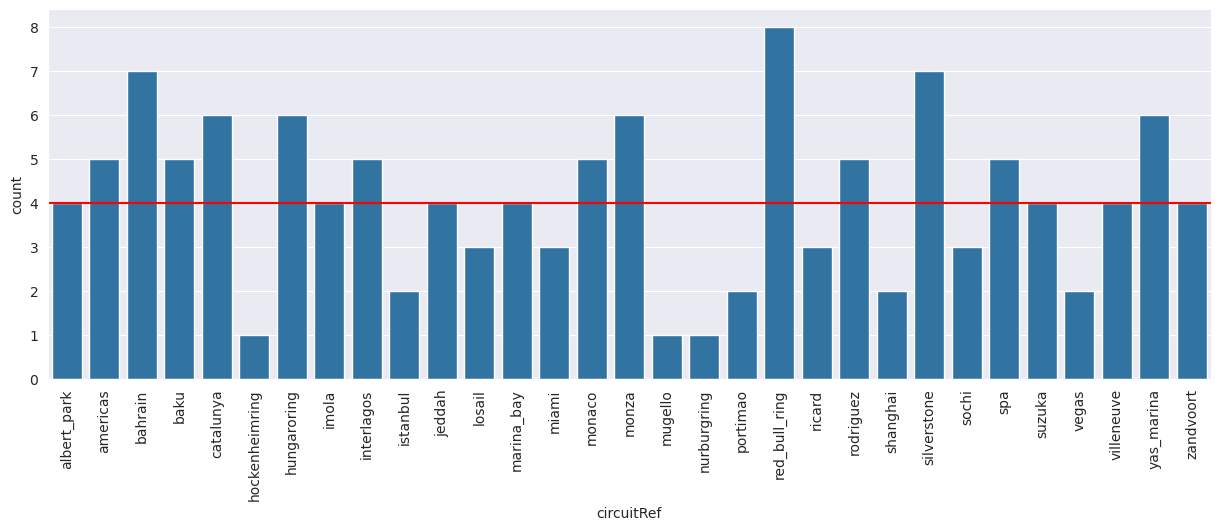

In [213]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.barplot(x=year_circuit['circuitRef'], y=year_circuit['count'])

ax.tick_params(axis='x', labelrotation=90)
ax.axhline(y=4, color='red')


En los seis años de análisis, red_bull_ring ha estado 8 veces, esto es porque durante la pandemia de COVID-19, el calendario se modificó, repitiendo circuitos

Para el propósito del análisis, vamos a considerar los circuitos que hayan sido ocupados cuatro o más veces

In [231]:
# filtrando circuitos de interés
circuits = year_circuit[year_circuit['count'] >= 4].circuitRef

races = races[races['circuitRef'].isin(circuits)]

In [242]:
# removiendo categorias no usadas
races['circuitRef'] = races['circuitRef'].cat.remove_unused_categories()

/tmp/ipykernel_12025/1224303025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races['circuitRef'] = races['circuitRef'].cat.remove_unused_categories()


Veamos la nueva distribución

In [246]:
races

,raceId,year,circuitRef,driverRef,alt,stop,pitlap,pitduration,startposition,endposition,...,fastestLapTime,fastestLapSpeed,lap,position,seconds,qposition,q1,q2,q3,status
0,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,1,19,146.128,20,86.067,0.000,0.0,+3 Laps
1,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,2,19,99.740,20,86.067,0.000,0.0,+3 Laps
2,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,3,19,92.317,20,86.067,0.000,0.0,+3 Laps
3,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,4,20,93.683,20,86.067,0.000,0.0,+3 Laps
4,1010,2019,albert_park,kubica,10,1,1,32.997,20,17,...,89.284,213.821,5,20,93.218,20,86.067,0.000,0.0,+3 Laps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269943,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,53,16,90.215,15,83.632,83.877,0.0,+1 Lap
269944,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,54,16,91.204,15,83.632,83.877,0.0,+1 Lap
269945,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,55,16,91.958,15,83.632,83.877,0.0,+1 Lap
269946,1144,2024,yas_marina,kevin_magnussen,3,4,55,22.090,14,16,...,85.637,222.002,56,16,112.994,15,83.632,83.877,0.0,+1 Lap


/tmp/ipykernel_12025/2381225073.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_circuit = races.groupby(['year', 'circuitRef', 'raceId'])


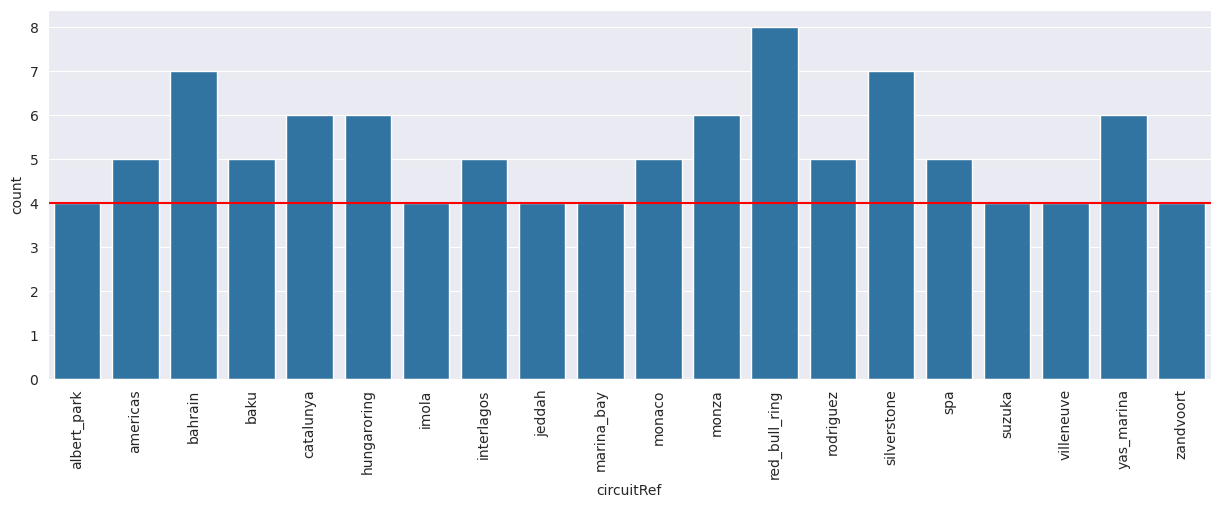

In [247]:
year_circuit = races.groupby(['year', 'circuitRef', 'raceId'])
year_circuit = year_circuit.nth(1)
year_circuit = year_circuit.circuitRef.value_counts().reset_index()

fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.barplot(x=year_circuit['circuitRef'], y=year_circuit['count'])

ax.tick_params(axis='x', labelrotation=90)
ax.axhline(y=4, color='red')

# Análisis Exploratorio (EDA)

Una vez filtrados los circuitos, haremos el EDA con el objetivo de identificar patrones y relaciones entre las variables, considerando que el análisis se hará por circuito, por ejemplo, 'rodriguez' se analizará en los 4 años viendo cómo ha cambiado

## medidas descriptivas por circuito, por año